In [1]:
sampSize = 10

In [14]:
%%time
from pycolator import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank', 'temp_score', 'percolator_score']

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)
features = [x for x in list(dSlow.columns) if (x not in excluded)]

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to ints...
file ready!
Wall time: 17.4 s


# TODO: MONTE CARLO SAMPLING INTO BOX PLOTS?

In [3]:
# set up metrices of original data set

oriIdents = [[]] * sampSize
oriExpectIdents = [[]] * sampSize
oriLen = [[]] * sampSize
oriAUCs = [[]] * sampSize
dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1]
    
for i in range(sampSize):
    for portion in range(12): # smallest df has 3 entries
        ix = list(dxl.index)
        newDf = dxl.loc[dxl['q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        oriExpectIdents[i].append(len(newDf.loc[newDf['q-val'] <= 0.01]))
        newDf = calcQ(newDf, 'NuXL:score')
        newIx = newDf.index
        #newIx = [x for i,x in enumerate(ix) if (i % (pow(2,portion)) == 0)]
        try:
            oriAUCs[i].append(pseudoROC(newDf, plot = False))
        except:
            oriAUCs[i].append(0.0)
        oriLen[i].append(len(newDf))
        oriIdents[i].append(len(newDf.loc[newDf['q-val'] <= 0.01]))

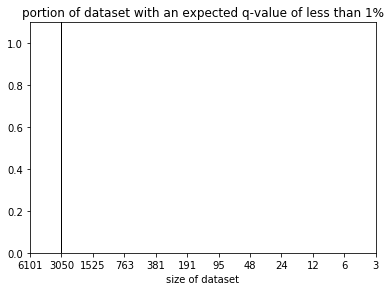

In [13]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_ylim(0,1.1)
x = range(12)
# y = [e/l for e,l in zip(oriExpectIdents,oriLen)]
y = [e/l for es,ls in zip(oriExpectIdents,oriLen) for e,l in zip(es,ls)]
# ax.plot(x, y)
ax.boxplot(x, list(zip(y)))
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(oriLen[0])
plt.show()

TypeError: unsupported operand type(s) for /: 'list' and 'list'

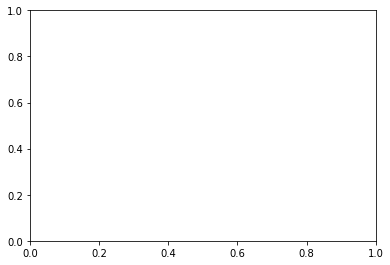

In [5]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
x = range(12)
y = [i/e if (e != 0) else np.nan for i,e in zip(oriIdents, oriExpectIdents)]
yUpper = max(2 - min(y), max(y)) + 0.1
ax.set_ylim(2 - yUpper, yUpper)
ax.plot(x, y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(oriLen)
plt.show()

In [ ]:
# calculate metrices of percolator results

# expected idents if algorithm would work as well as NuXL:score
expId = [[]] * sampSize

# expected idents if the algorithm would work as well as with the whole data set
pExpectIdents = [[]] * sampSize

pIdents = [[]] * sampSize
pLen = [[]] * sampSize
pAUCs = [[]] * sampSize

saveName = ''

iters = 12 # smallest df has 3 entries
for i in range(sampSize):
    for portion in range(iters):
        dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1]

        ix = list(dxl.index)
        newDf = dxl.loc[dxl['q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        expId[i].append(len(newDf.loc[newDf['q-val'] <= 0.01]))
        newIx = newDf.index

        try:
            pxl = percolator_experimental(newDf, idCol, features, plotSaveName = saveName, plotXLnXL = False)
        except:
            print('Dataset too small: {} PSMs. Quitting evaluation.'.format(len(newDf)))
            iters = portion
            del expId[-1]
            break

        if (portion == 0):
            fullP = pd.DataFrame(pxl.loc[:,['Label', 'percolator_score', 'q-val']])

        # maybe calc Q with sampled subset of fullP?
        pExpectIdents[i].append(len(fullP.loc[(fullP.index.isin(newIx)) & (fullP['q-val'] <= 0.01)]))

        try:
            pAUCs[i].append(pseudoROC(newDf, plot = False))
        except:
            print('Error while calculating AUC in iteration {}/{}!'.format(portion + 1, iters))
            pAUCs[i].append(0.0)
        pLen[i].append(len(pxl))
        pIdents[i].append(len(pxl.loc[pxl['q-val'] <= 0.01]))

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.ylim(0,1.1)
x = range(iters)
y = [e/l for e,l in zip(pExpectIdents,pLen)]
ax.plot(x, y)
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(pLen)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
yUpper = max(2 - min(y), max(y)) + 0.1
ax.set_ylim(2 - yUpper, yUpper)
x = range(iters)
y = [i/e if (e != 0) else np.nan for i,e in zip(pIdents, pExpectIdents)]
ax.plot(x, y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(oriLen)
plt.show()

In [ ]:
x = range(iters)
ratioAUCs = [p / o if (o!=0) else p + 1 for p,o in zip(pAUCs,oriAUCs)]
ratioIdents = [p / o for p,o in zip(pIdents,oriIdents)]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
yUpper = max(2 - min([a for a in ratioAUCs if a != 0]), max(ratioAUCs)) + 0.1
ax.set_ylim(2 - yUpper, yUpper)
ax.plot(x, ratioAUCs)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of AUCs of percolator vs NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
yUpper = max(2 - min(ratioIdents), max(ratioIdents)) + 0.1
ax.set_ylim(2 - yUpper, yUpper)
ax.plot(x,ratioIdents)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of Idents at 1% of percolator vs NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen)
plt.show()